# Compare RL Control with PID Control tuned by RL <br> / RL Control과 RL로 튜닝한 PID Control 비교

In [1]:
import gym
import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
import cv2
import time
%matplotlib inline

is_ipython = 'inline' in plt.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

## Check state[4] (angle) / state[4] (각도) 확인하기

Befor Setting angle as set point of PID control, check what angle is.

In [2]:
env = gym.make("LunarLander-v2")

In [3]:
'''
s[0] is the horizontal coordinate
s[1] is the vertical coordinate
s[2] is the horizontal speed
s[3] is the vertical speed
s[4] is the angle
s[5] is the angular speed
s[6] 1 if first leg has contact, else 0
s[7] 1 if second leg has contact, else 0
'''

'\ns[0] is the horizontal coordinate\ns[1] is the vertical coordinate\ns[2] is the horizontal speed\ns[3] is the vertical speed\ns[4] is the angle\ns[5] is the angular speed\ns[6] 1 if first leg has contact, else 0\ns[7] 1 if second leg has contact, else 0\n'

In [4]:
env.reset()
angles = []
imgs = []
for _ in range(50):
    result = env.step(1)
    angles.append(result[0][4])
    imgs.append(env.render(mode='rgb_array'))
env.close()

In [5]:
def check_angle(angles, imgs):
    T = 50
    plt.figure(figsize=(10,400))
    for i in range(T):
        ax = plt.subplot(T,1,i+1)
        ax.set_title(str(angles[i]))
        ax.imshow(imgs[i])

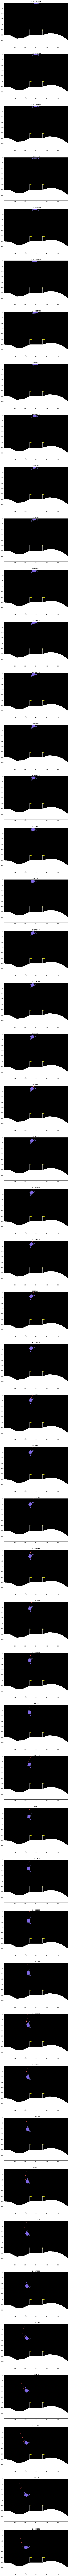

In [6]:
check_angle(angles,imgs)

In [7]:
env.reset()
angles = []
imgs = []
for _ in range(50):
    result = env.step(3)
    angles.append(result[0][4])
    imgs.append(env.render(mode='rgb_array'))
env.close()

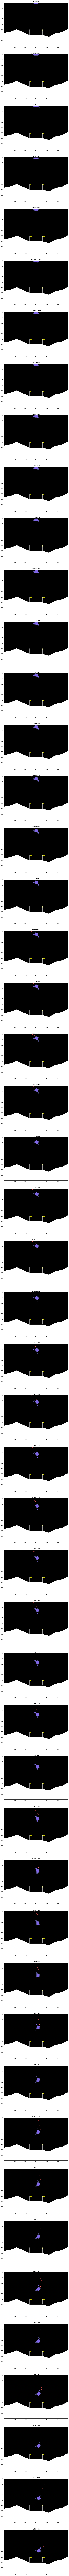

In [8]:
check_angle(angles, imgs)

In [9]:
state = env.reset()
origin_vertical = state[1]
origin_horizontal = state[0]
done = False
action = 0

main_engine_on_during = 5
main_engine_on_count = 0

side_engine_on_during = 20
side_engine_on_count = 0


print('origin : ',origin_horizontal)
print()

while not done:
    env.render()
    n_state, reward, done, info = env.step(action)
    if n_state[5]<0:
        action=1
    else:
        action=3
    
    if side_engine_on_count%side_engine_on_during == 0:
        if n_state[2] < 0:
            action=3
        elif n_state[2] > 0:
            action=1
    side_engine_on_count += 1
    
    if n_state[3] < 0 and main_engine_on_count%main_engine_on_during != 0:
        action=2
    main_engine_on_count += 1
    
    time.sleep(0.01)
    
    print(f'angular speed:{n_state[5]:+0.3f}, horizontal cord:{n_state[0]:+0.3f}, horizontal speed:{n_state[2]:+0.3f},vertical speed:{n_state[3]:+0.3f}', end='\r')
    
env.close()

origin :  0.0056697847



## Check continuous action space / 연속 행동 공간에서 살펴보기

In [10]:
cenv = gym.make("LunarLanderContinuous-v2")

In [11]:
state = cenv.reset()
origin_vertical = state[1]
origin_horizontal = state[0]
done = False
action = [0,0]

while not done:
    cenv.render()
    n_state, reward, done, info = cenv.step(action)
    if n_state[5]<0:
        action[1]=n_state[5]*50 + (2 - (n_state[2]<0) + (n_state[2]>0)) * -n_state[2]*10 + (2 - (n_state[0]<0) + (n_state[0]>0)) * -n_state[0]
    elif n_state[5]>0: 
        action[1]=n_state[5]*50 + (2 - (n_state[2]<0) + (n_state[2]>0)) * -n_state[2]*10 + (2 - (n_state[0]<0) + (n_state[0]>0)) * -n_state[0]
        
    if n_state[3]<0:
        action[0]=abs(n_state[3])*5
        
    time.sleep(0.01)
    
    print(f'action:[{action[0]:+0.2f},{action[1]:+0.2f}], a s:{n_state[5]:+0.3f}, h c:{n_state[0]:+0.3f}, h s:{n_state[2]:+0.3f},v s:{n_state[3]:+0.3f}', end='\r')
    
cenv.close()

## Apply PID control to side engines + apply keyboard control  <br> / Side engines에 PID control 적용 + 키보드 조작 적용

In [12]:
import gym
import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
import cv2
import time

from PID import PID

cenv = gym.make("LunarLanderContinuous-v2")

SKIP_CONTROL = 0    # Use previous control decision SKIP_CONTROL times, that's how you
                    # can test what skip is still usable.

side_engine_control = 0
main_engine_control = 0
engine_off = False

human_wants_restart = False
human_sets_pause = False

'''
    a : left(right side engine on)
    d : right(left side engine on)
    s : down(main engine power down)
    w : up(main engine power up)
    q : engine off
'''

def key_press(key, mod):
    global side_engine_control, main_engine_control, engine_off, human_wants_restart, human_sets_pause
    if key==0xff0d: human_wants_restart = True  # Enter
    if key==32: human_sets_pause = not human_sets_pause # Space
    a = int(key)
    if a <= 0: return
    if a==ord('a'):
        side_engine_control = 0.3
    if a==ord('d'):
        side_engine_control = -0.3
    if a==ord('s'):
        main_engine_control = -0.3
    if a==ord('w'):
        main_engine_control = 0.3
    if a==ord('q'):
        engine_off=True

def key_release(key, mod):
    global side_engine_control, main_engine_control, engine_off
    if side_engine_control == -0.3 or side_engine_control == 0.3:
        side_engine_control = 0
    if main_engine_control == -0.3 or main_engine_control == 0.3:
        main_engine_control = 0
    if engine_off == True:
        engine_off = False

cenv.render()
cenv.unwrapped.viewer.window.on_key_press = key_press
cenv.unwrapped.viewer.window.on_key_release = key_release

def rollout(env):
    global side_engine_control, main_engine_control, engine_off, human_wants_restart, human_sets_pause
    
    human_wants_restart = False
    
    state = cenv.reset()
    done = False
    action = [0,0]
    
    # apply PID
    apid = PID(1.253136190601821, 0.620026107056804, -0.002720052821954503)
    vpid = PID(1.253136190601821, 0.620026107056804, -0.002720052821954503)
    apid.SetPoint=0
    vpid.SetPoint=0
    
    # cummulated reward
    cr = 0
    
    # PID plots
    apid_sp_list, apid_fb_list = [], []
    vpid_sp_list, vpid_fb_list = [], []

    while not done:
     
        window_still_open = cenv.render()
        n_state, reward, done, info = cenv.step(action)
        
        # PID control
        apid.SetPoint=side_engine_control
        vpid.SetPoint=main_engine_control
        
        apid_sp_list.append(apid.SetPoint)
        vpid_sp_list.append(vpid.SetPoint)

        apid.update(n_state[4])
        action[1] = (-apid.output*2.5 + n_state[5])*20

        vpid.update(n_state[3])
        action[0] = vpid.output
        
        apid_fb_list.append(n_state[4])
        vpid_fb_list.append(n_state[3])

        time.sleep(0.01)

        if engine_off:
            action = [0, 0]

        print(f'action:[{action[0]:+0.2f},{action[1]:+0.2f}], as:{n_state[5]:+0.3f},vs:{n_state[3]:+0.3f}, vsp:{vpid.SetPoint:+0.1f}, asp:{apid.SetPoint:+0.1f}', end='\r')
        cr+=reward
        
        if window_still_open==False: return False
        if human_wants_restart: break
        while human_sets_pause:
            cenv.render()
            time.sleep(0.1)
    print()
    print("reward:",cr)
    
    return apid_sp_list, apid_fb_list, vpid_sp_list, vpid_fb_list

apid_sp_list, apid_fb_list, vpid_sp_list, vpid_fb_list = window_still_open = rollout(cenv)
cenv.close()

action:[+0.00,+0.00], as:+0.000,vs:+0.000, vsp:+0.0, asp:+0.00
reward: 171.34275322347753


### Check PID plots

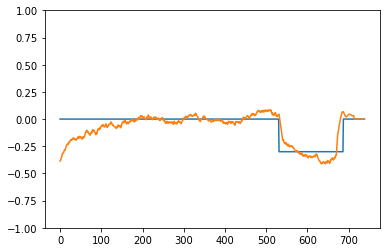

In [13]:
plt.ylim(-1,1)
plt.plot(vpid_sp_list)
plt.plot(vpid_fb_list)

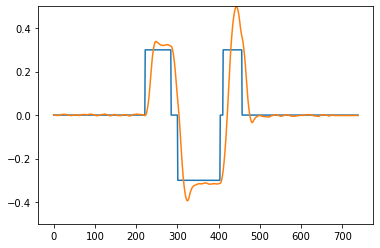

In [14]:
plt.ylim(-0.5,0.5)
plt.plot(apid_sp_list)
plt.plot(apid_fb_list)